In [1]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

In [2]:
# 이미지 출력, 행렬 변환을 위한 matplotlib, numpy import
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np

In [3]:
# hyperparameters
EPOCH = 10
BATCH_SIZE = 64
USE_CUDA = torch.cuda.is_available()
device = torch.device('cuda' if USE_CUDA else 'cpu')
print('Using device : ', device)

Using device :  cpu


In [4]:
# Fashion MNIST
# 정답이 없기 때문에 학습 데이터셋만 사용
trainset = datasets.FashionMNIST(
    root='./.data',
    train=True, download=True,
    transform = transforms.ToTensor()
)

train_loader = torch.utils.data.DataLoader(
    dataset=trainset,
    batch_size=BATCH_SIZE, shuffle=True, num_workers=2
)

In [5]:
# Autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # encoder : 진행하며 특징을 3개만 남김
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3)
        )
        
        # decoder : 남은 특징을 바탕으로 원본 크기로 복원
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid() # 출력값을 0과 1로
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [6]:
model = Autoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.005)
criterion = nn.MSELoss() # loss

In [7]:
# noise 발생 함수
def add_noise(img):
    noise = torch.randn(img.size()) * 0.2
    noisy_img = img + noise
    return noisy_img

In [8]:
def train(model, train_loader):
    model.train()
    avg_loss = 0
    for step, (x, label) in enumerate(train_loader):
        # 입력을 noisy한 이미지로 변경
        x = add_noise(x)
        x = x.view(-1, 28*28).to(device)
        y = x.view(-1, 28*28).to(device)
        label = label.to(device)
        
        encoded, decoded = model(x)
        
        loss = criterion(decoded, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        avg_loss += loss.item()
    return avg_loss / len(train_loader)

In [9]:
for epoch in range(1, EPOCH + 1):
    loss = train(model, train_loader)
    print('[Epoch {}] loss: {}'.format(epoch, loss))

[Epoch 1] loss: 0.07622320055246734
[Epoch 2] loss: 0.06573518333849368
[Epoch 3] loss: 0.06416784648273165
[Epoch 4] loss: 0.06350540939662884
[Epoch 5] loss: 0.06295706852396796
[Epoch 6] loss: 0.06277175731003792
[Epoch 7] loss: 0.06243269295215225
[Epoch 8] loss: 0.06229739628636888
[Epoch 9] loss: 0.06219822981321354
[Epoch 10] loss: 0.062044100875634625


# 이미지 복원 확인하기

In [10]:
# 학습되지 않은 testset 생성
testset = datasets.FashionMNIST(
    root='./.data',
    train=False, download=True,
    transform = transforms.ToTensor()
)

In [11]:
# 이미지 한 장 샘플
sample_data = testset.test_data[0].view(-1, 28*28)
sample_data = sample_data.type(torch.FloatTensor)/255.

/home/handong/.pyenv/versions/3.6.5/lib/python3.6/site-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


In [12]:
# 이미지에 노이즈를 더한 후 모델에 테스트
original_x = sample_data[0]
noisy_x = add_noise(original_x).to(device)
_, recovered_x = model(noisy_x)

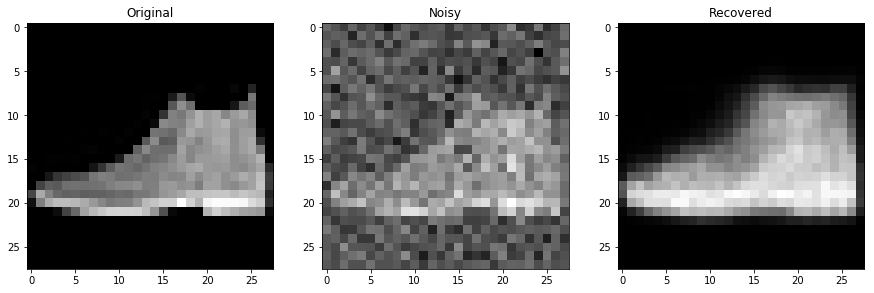

In [13]:
# 시각화
f, a = plt.subplots(1, 3, figsize=(15, 15))

original_img = np.reshape(original_x.to('cpu').data.numpy(), (28, 28))
noisy_img = np.reshape(noisy_x.to('cpu').data.numpy(), (28, 28))
recovered_img = np.reshape(recovered_x.to('cpu').data.numpy(), (28, 28))

# original
a[0].set_title('Original')
a[0].imshow(original_img, cmap='gray')

# noisy
a[1].set_title('Noisy')
a[1].imshow(noisy_img, cmap='gray')

# recovered
a[2].set_title('Recovered')
a[2].imshow(recovered_img, cmap='gray')

plt.show()